# NOAA 1158: Timelag Analysis
We carry out a timelag analysis (similar to the many papers of Viall and Klimchuk) using our synthesized AR maps.

In [1]:
import os
import copy
import glob

import numpy as np
import scipy.signal
import scipy.ndimage
from scipy.interpolate import splev
import dask
import dask.distributed
import matplotlib.pyplot as plt
import matplotlib.colors
from sunpy.map import Map,GenericMap
import astropy.units as u
import astropy.constants as const
from astropy.utils.console import ProgressBar

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA

%matplotlib inline

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
client = dask.distributed.Client()
client

Client Scheduler: tcp://127.0.0.1:45298 Dashboard: http://127.0.0.1:8787,Cluster Workers: 64 Cores: 64 Memory: 162.23 GB


In [3]:
data_root = '/storage-home/w/wtb2/data/'

We want to calculate the timelags, defined as the time delay which gives the maximum cross-correlation, between channel pairs in each pixel of our simulated SDO/AIA maps of NOAA 1158. We'll do this for four different cases,

* cooling only
* high-frequency heating
* intermediate-frequency heating
* low-frequency heating

We'll consider the following the channel pairs:

* 94-335 Å
* 94-171 Å
* 335-211 Å
* 335-171 Å
* 193-171 Å
* 171-131 Å

We define the timelag channel pair such that a positive timelag indicates the variation  in the second channel follows the variation in the first channel.

In [4]:
aia = InstrumentSDOAIA([0,1e4]*u.s)

The AIA response functions are plotted below. Generally, they target different areas of the temperature range between $10^5$ K and a bit over $10^7$ K, though several are double peaked. This makes interpretation of some channel pairs difficult.

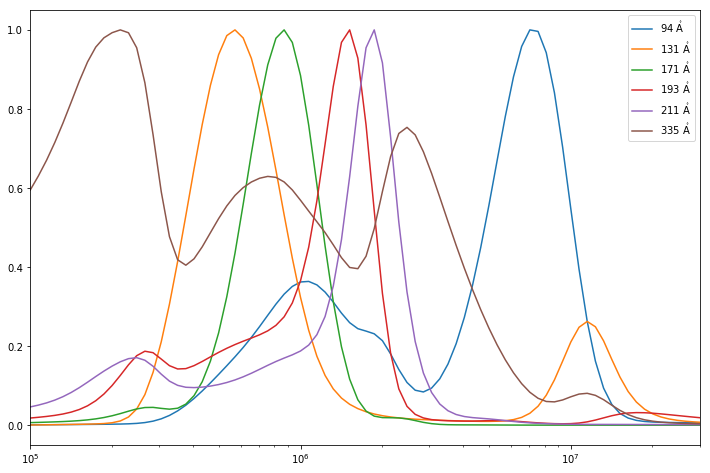

In [5]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca()
temperature = np.logspace(5,8,100)
for channel in aia.channels:
    y = splev(temperature,channel['temperature_response_spline'])
    ax.plot(temperature,y/y.max(),
            label=r'{} $\mathring{{\mathrm{{A}}}}$'.format(channel['name']))
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim([1e5,3e7])
#ax.set_ylim([1e-30,2e-24])
ax.legend(loc='best')

In [6]:
def single_pixel_lc(xcoords,ycoords,map_cubes):
    fig,axes = plt.subplots(1,2,figsize=(20,8))
    for c in aia.channels:
        ts = map_cubes[c['name']][ycoords[0]:ycoords[1],xcoords[0]:xcoords[1],:].mean(axis=(0,1))
        ts /= ts.max()
        axes[0].plot(aia.observing_time,ts,label=c['name'])
    axes[0].legend()
    #axes[0].set_xlim([0,2000])
    for p in [('335','171'),('171','131'),('193','171'),('335','211'),('94','171'),('94','335')]:
        ts_a = map_cubes[p[0]][ycoords[0]:ycoords[1],xcoords[0]:xcoords[1],:].mean(axis=(0,1))
        ts_a /= ts.max()
        ts_b = map_cubes[p[1]][ycoords[0]:ycoords[1],xcoords[0]:xcoords[1],:].mean(axis=(0,1))
        ts_b /= ts.max()
        cc = np.fft.irfft(
            np.fft.rfft(ts_a[::-1],n=timelags.shape[0])*np.fft.rfft(ts_b,n=timelags.shape[0]),
            n=timelags.shape[0]
        )#scipy.signal.correlate(ts_b,ts_a)
        axes[1].plot(timelags,cc/cc.max(),label=r'{}-{}'.format(*p))
    axes[1].set_xlim([-6000,6000])
    axes[1].legend(loc='best')

In [7]:
x0,x1 = 199,201#198,199
y0,y1 = 199,201#414,415

In [8]:
def make_timelag_map(cubes,channel_a,channel_b,map_meta):
    chan_a_cube = cubes[channel_a]/np.where(cubes[channel_a].max(axis=2)==0,1.,
                                            cubes[channel_a].max(axis=2))[:,:,np.newaxis]
    chan_b_cube = cubes[channel_b]/np.where(cubes[channel_b].max(axis=2)==0,1.,
                                            cubes[channel_b].max(axis=2))[:,:,np.newaxis]
    fft_a = dask.array.fft.rfft(dask.array.from_array(chan_a_cube[:,:,::-1],chunks=(20,20)+aia.observing_time.shape),
                                axis=2,n=timelags.shape[0])
    fft_b = dask.array.fft.rfft(dask.array.from_array(chan_b_cube,chunks=(20,20)+aia.observing_time.shape),
                                axis=2,n=timelags.shape[0])
    cc_ab = dask.array.fft.irfft(fft_a*fft_b,axis=2,n=timelags.shape[0]).compute()
    
    max_correlation = np.max(cc_ab,axis=2)
    max_timelag = timelags[np.argmax(cc_ab,axis=2)]
    
    timelag_map = GenericMap(np.where(max_correlation<1.,0,max_timelag),map_meta.copy())
    correlation_map = GenericMap(max_correlation,map_meta.copy())
    
    return timelag_map,correlation_map

## Cooling Only

In [9]:
timelags = np.hstack([-aia.observing_time.value[1:][::-1],aia.observing_time.value])*aia.observing_time.unit

In [10]:
map_cubes_cooling = {c['name']:None for c in aia.channels}

In [11]:
with ProgressBar(len(aia.channels)*aia.observing_time.shape[0],ipython_widget=True) as progress:
    for channel in aia.channels:
        map_files = sorted(
            glob.glob(
                os.path.join(data_root,'noaa1158_cooling_model/SDO_AIA/{}/*.fits'.format(channel['name']))
            )
        )
        for i,mf in enumerate(map_files):
            tmp = Map(mf)
            if map_cubes_cooling[channel['name']] is None:
                map_cubes_cooling[channel['name']] = np.empty(tmp.data.shape+aia.observing_time.shape)
            map_cubes_cooling[channel['name']][:,:,i] = tmp.data
            progress.update()


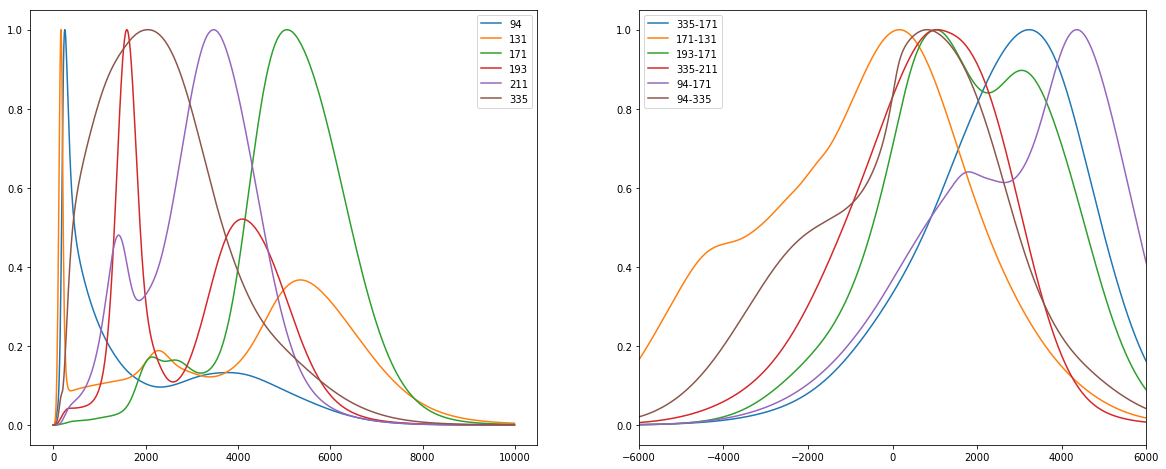

In [12]:
single_pixel_lc((x0,x1),(y0,y1),map_cubes_cooling)

In [13]:
delay_map_cooling,correlation_map_cooling = make_timelag_map(map_cubes_cooling,'335','171',tmp.meta)

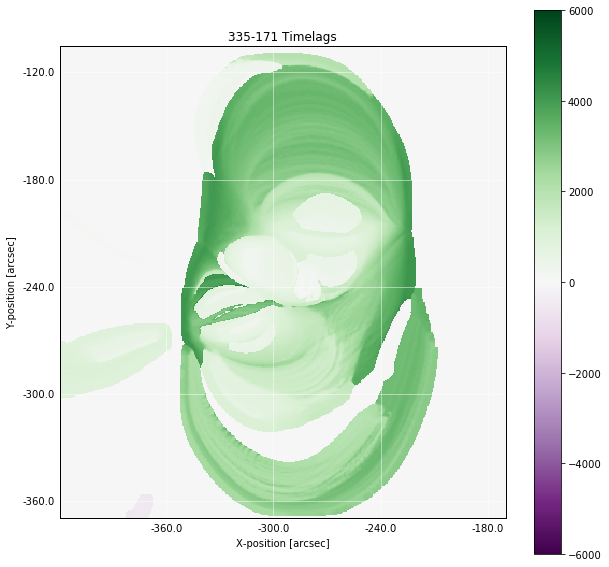

In [17]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection=delay_map_cooling)
delay_map_cooling.plot(axes=ax,cmap=plt.get_cmap('PRGn'),vmin=-6000,vmax=6000,title=False)
ax.set_title(r'335-171 Timelags')
plt.colorbar()

In [18]:
delay_map_cooling_94_171,correlation_map_cooling_94_171 = make_timelag_map(map_cubes_cooling,'94','171',tmp.meta)

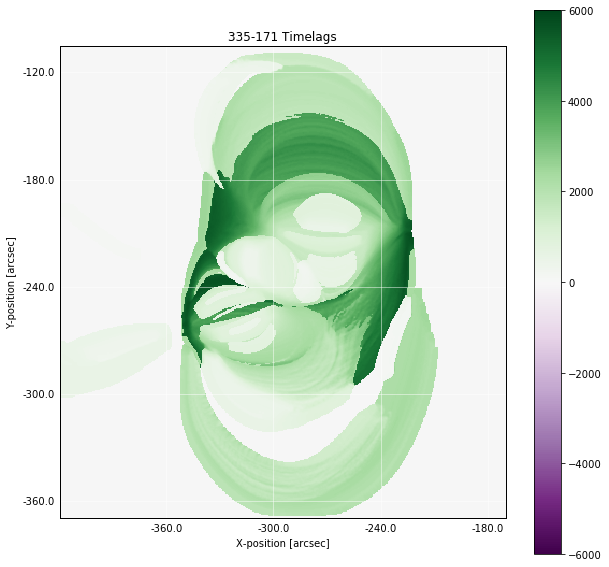

In [19]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection=delay_map_cooling_94_171)
delay_map_cooling_94_171.plot(axes=ax,cmap=plt.get_cmap('PRGn'),vmin=-6000,vmax=6000,title=False)
ax.set_title(r'335-171 Timelags')
plt.colorbar()

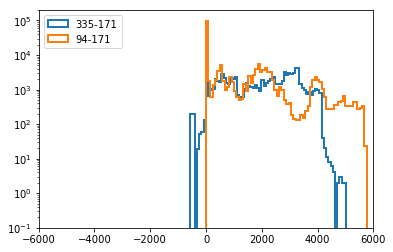

In [21]:
plt.hist(delay_map_cooling.data.flatten(),log=True,bins='scott',histtype='step',lw=2,label=r'335-171');
plt.hist(delay_map_cooling_94_171.data.flatten(),log=True,bins='scott',histtype='step',lw=2,label=r'94-171');
plt.xlim([-6000,6000])
plt.legend()

## High frequency

In [22]:
map_cubes_hf = {c['name']:None for c in aia.channels}

In [23]:
with ProgressBar(len(aia.channels)*aia.observing_time.shape[0],ipython_widget=True) as progress:
    for channel in aia.channels:
        map_files = sorted(
            glob.glob(
                os.path.join(data_root,'noaa1158_high_frequency/SDO_AIA/{}/*.fits'.format(channel['name']))
            )
        )
        for i,mf in enumerate(map_files):
            tmp = Map(mf)
            if map_cubes_hf[channel['name']] is None:
                map_cubes_hf[channel['name']] = np.empty(tmp.data.shape+aia.observing_time.shape)
            map_cubes_hf[channel['name']][:,:,i] = tmp.data
            progress.update()

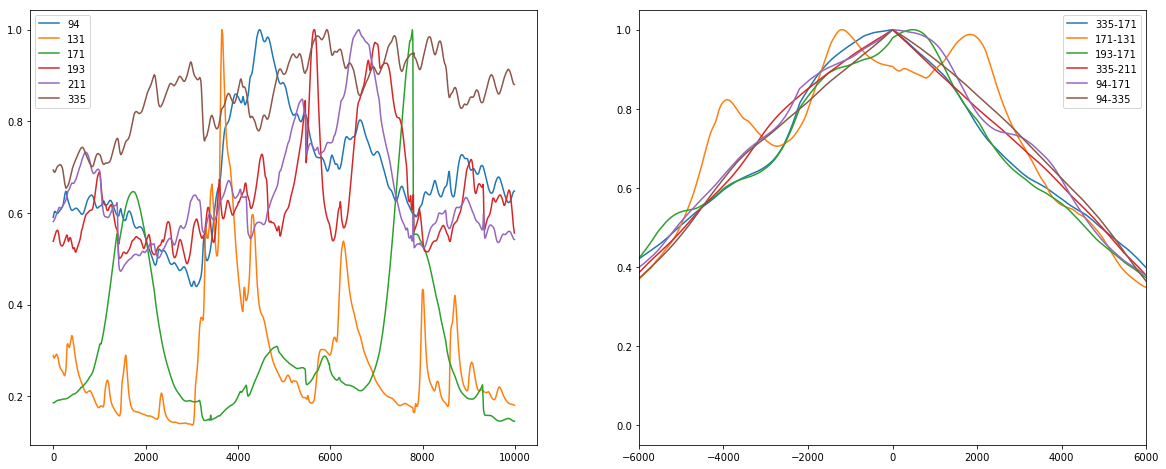

In [24]:
single_pixel_lc((x0,x1),(y0,y1),map_cubes_hf)

In [26]:
delay_map_hf_335_171,correlation_map_hf_335_171 = make_timelag_map(map_cubes_hf,'335','171',tmp.meta)

In [29]:
delay_map_hf_94_171,correlation_map_hf_94_171 = make_timelag_map(map_cubes_hf,'94','171',tmp.meta)

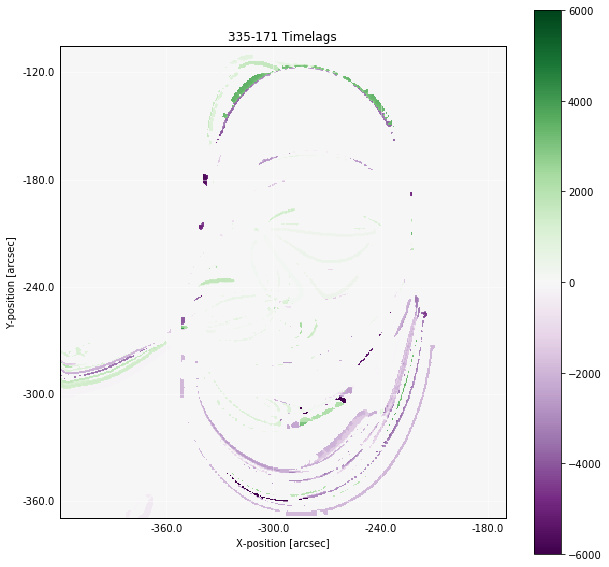

In [28]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection=delay_map_hf_335_171)
delay_map_hf_335_171.plot(axes=ax,cmap=plt.get_cmap('PRGn'),vmin=-6000,vmax=6000,title=False)
ax.set_title(r'335-171 Timelags')
plt.colorbar()

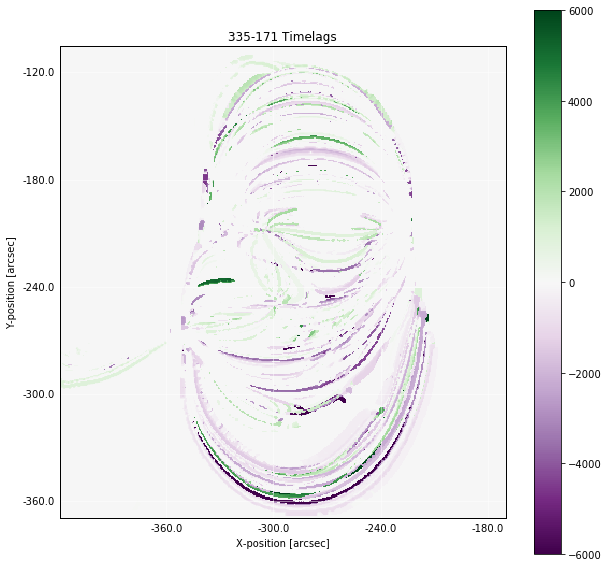

In [30]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection=delay_map_hf_94_171)
delay_map_hf_94_171.plot(axes=ax,cmap=plt.get_cmap('PRGn'),vmin=-6000,vmax=6000,title=False)
ax.set_title(r'335-171 Timelags')
plt.colorbar()

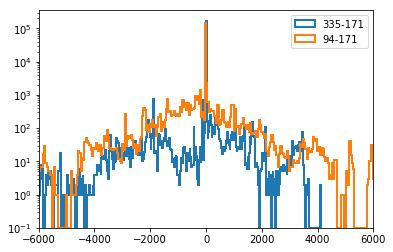

In [32]:
plt.hist(delay_map_hf_335_171.data.flatten(),log=True,bins='scott',histtype='step',lw=2,label=r'335-171');
plt.hist(delay_map_hf_94_171.data.flatten(),log=True,bins='scott',histtype='step',lw=2,label=r'94-171');
plt.xlim([-6000,6000])
plt.legend()

## Intermediate frequency

In [33]:
map_cubes_if = {c['name']:None for c in aia.channels}

In [34]:
with ProgressBar(len(aia.channels)*aia.observing_time.shape[0],ipython_widget=True) as progress:
    for channel in aia.channels:
        map_files = sorted(
            glob.glob(
                os.path.join(data_root,'noaa1158_intermediate_frequency/SDO_AIA/{}/*.fits'.format(channel['name']))
            )
        )
        for i,mf in enumerate(map_files):
            tmp = Map(mf)
            if map_cubes_if[channel['name']] is None:
                map_cubes_if[channel['name']] = np.empty(tmp.data.shape+aia.observing_time.shape)
            map_cubes_if[channel['name']][:,:,i] = tmp.data
            progress.update()

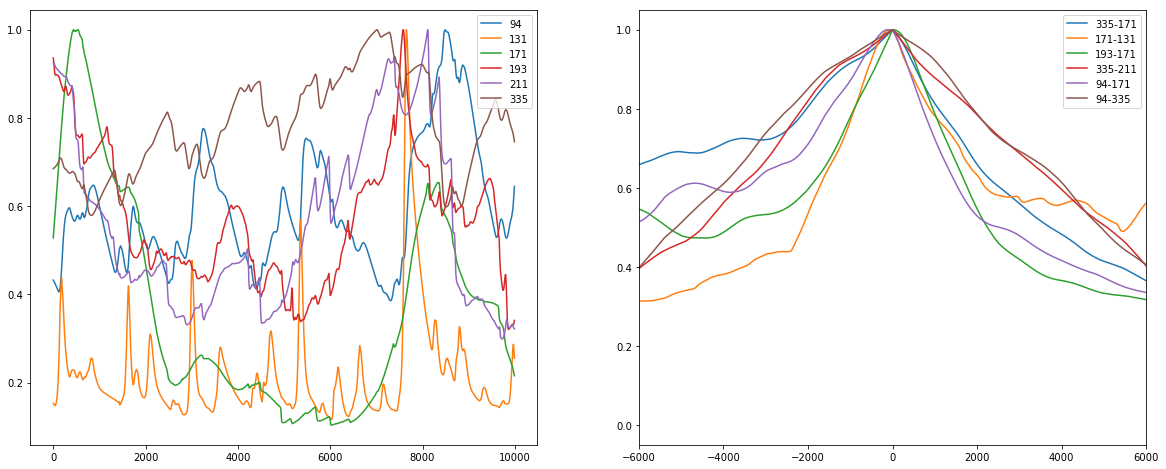

In [35]:
single_pixel_lc((x0,x1),(y0,y1),map_cubes_if)

In [38]:
delay_map_if_335_171,correlation_map_if_335_171 = make_timelag_map(map_cubes_if,'335','171',tmp.meta)

In [40]:
delay_map_if_94_171,correlation_map_if_94_171 = make_timelag_map(map_cubes_if,'94','171',tmp.meta)

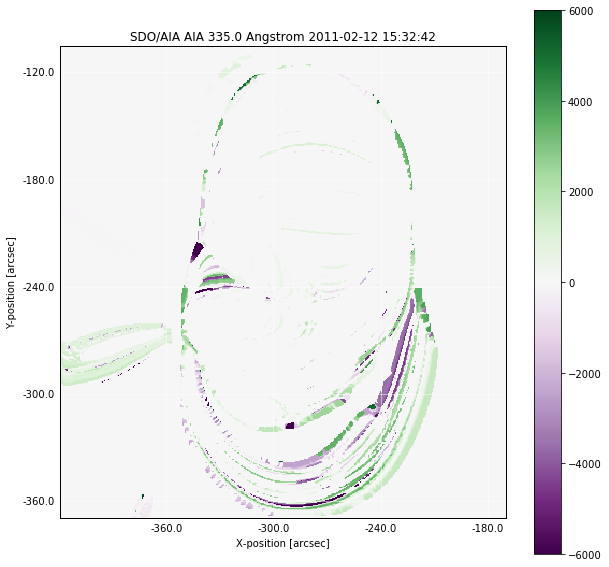

In [39]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection=delay_map_if_335_171)
delay_map_if_335_171.plot(axes=ax,cmap=plt.get_cmap('PRGn'),vmin=-6000,vmax=6000)
plt.colorbar()

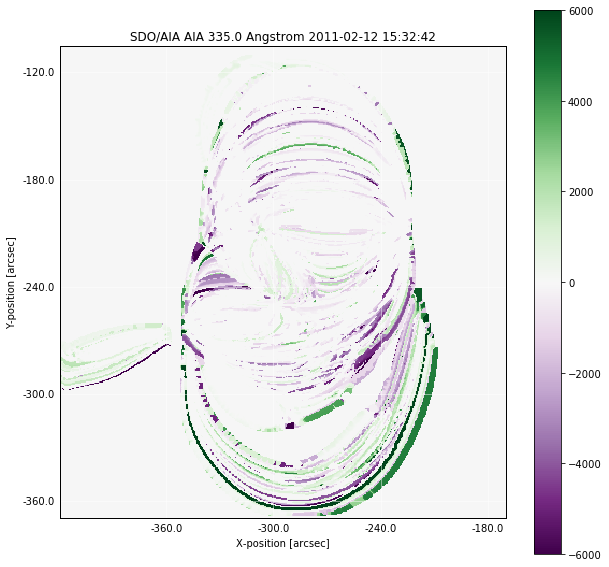

In [41]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection=delay_map_if_94_171)
delay_map_if_94_171.plot(axes=ax,cmap=plt.get_cmap('PRGn'),vmin=-6000,vmax=6000)
plt.colorbar()

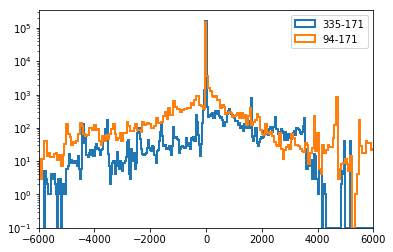

In [42]:
plt.hist(delay_map_if_335_171.data.flatten(),log=True,bins='scott',histtype='step',lw=2,label=r'335-171');
plt.hist(delay_map_if_94_171.data.flatten(),log=True,bins='scott',histtype='step',lw=2,label=r'94-171');
plt.xlim([-6000,6000])
plt.legend()

## Low frequency

In [43]:
map_cubes_lf = {c['name']:None for c in aia.channels}

In [44]:
with ProgressBar(len(aia.channels)*aia.observing_time.shape[0],ipython_widget=True) as progress:
    for channel in aia.channels:
        map_files = sorted(
            glob.glob(
                os.path.join(data_root,'noaa1158_low_frequency/SDO_AIA/{}/*.fits'.format(channel['name']))
            )
        )
        for i,mf in enumerate(map_files):
            tmp = Map(mf)
            if map_cubes_lf[channel['name']] is None:
                map_cubes_lf[channel['name']] = np.empty(tmp.data.shape+aia.observing_time.shape)
            map_cubes_lf[channel['name']][:,:,i] = tmp.data
            progress.update()

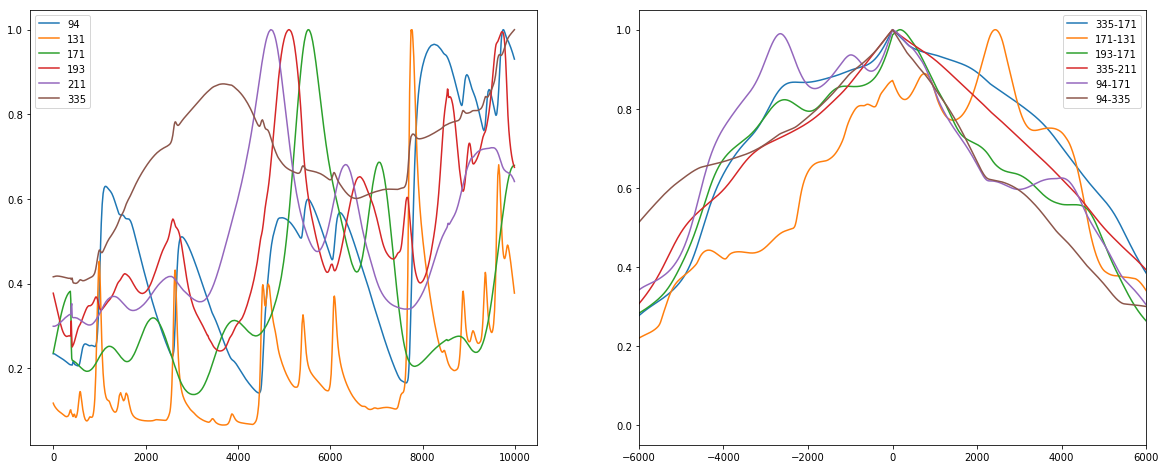

In [45]:
single_pixel_lc((x0,x1),(y0,y1),map_cubes_lf)

In [46]:
delay_map_lf_335_171,correlation_map_lf_335_171 = make_timelag_map(map_cubes_lf,'335','171',tmp.meta)

In [48]:
delay_map_lf_94_171,correlation_map_lf_94_171 = make_timelag_map(map_cubes_lf,'94','171',tmp.meta)

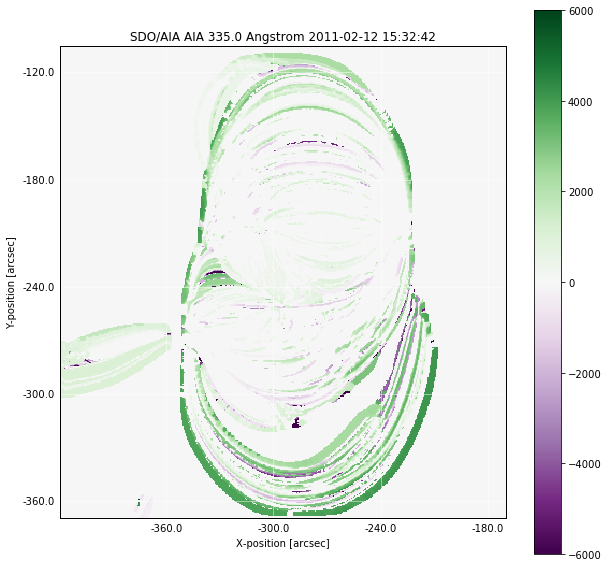

In [47]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection=delay_map_lf_335_171)
delay_map_lf_335_171.plot(axes=ax,cmap=plt.get_cmap('PRGn'),vmin=-6000,vmax=6000)
plt.colorbar()

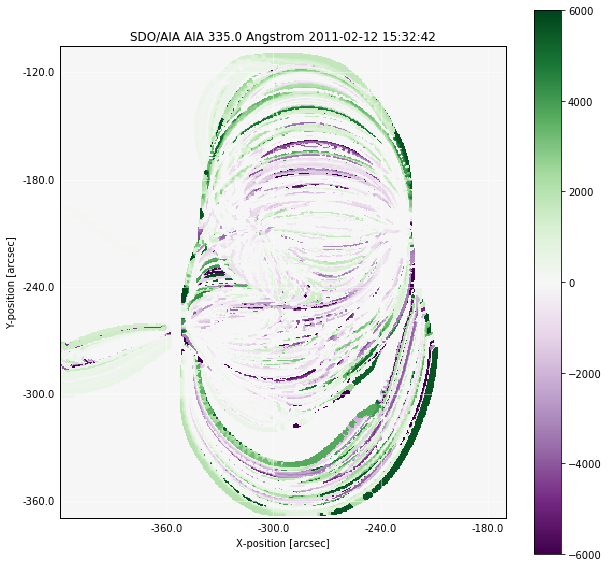

In [49]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection=delay_map_lf_94_171)
delay_map_lf_94_171.plot(axes=ax,cmap=plt.get_cmap('PRGn'),vmin=-6000,vmax=6000)
plt.colorbar()

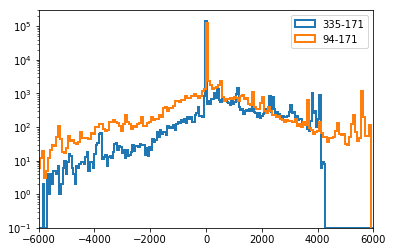

In [50]:
plt.hist(delay_map_lf_335_171.data.flatten(),log=True,bins='scott',histtype='step',lw=2,label=r'335-171');
plt.hist(delay_map_lf_94_171.data.flatten(),log=True,bins='scott',histtype='step',lw=2,label=r'94-171');
plt.xlim([-6000,6000])
plt.legend()

## Compare Timelag Distributions

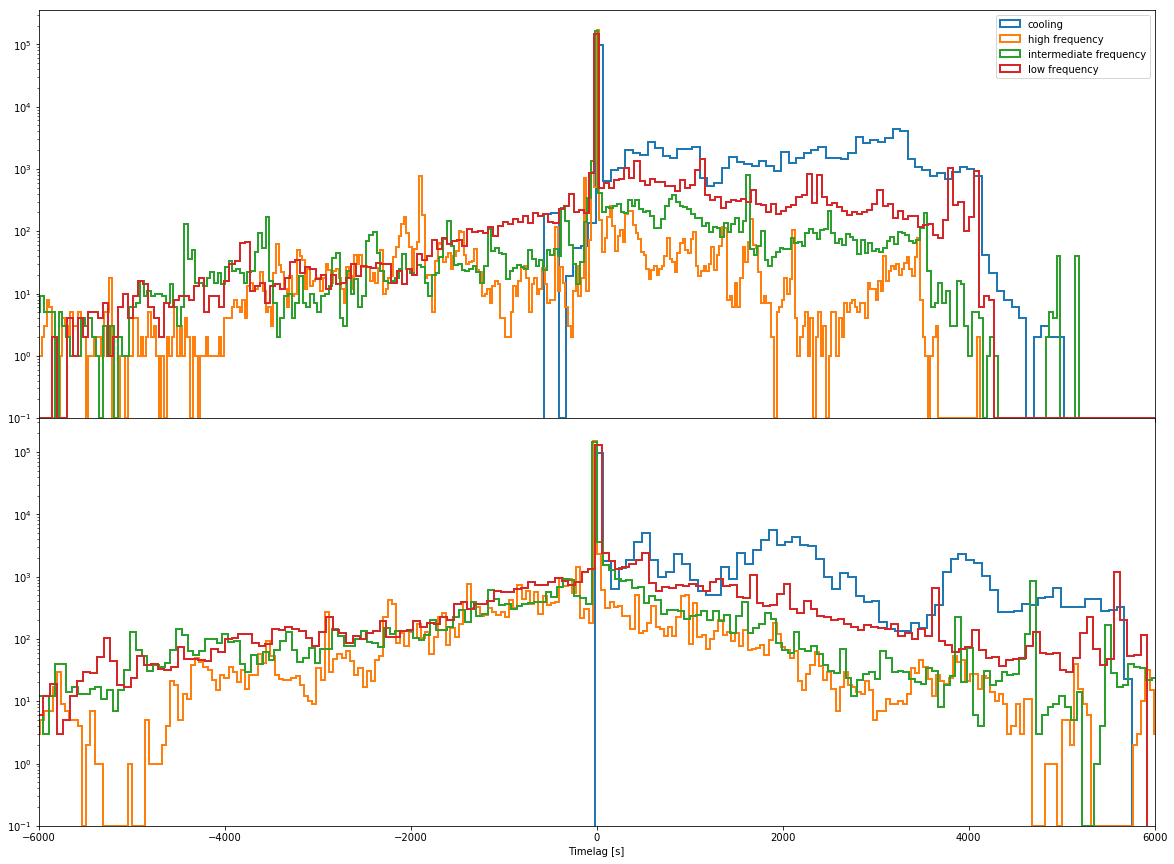

In [58]:
fig,ax = plt.subplots(2,1,figsize=(20,15),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0.)
params = {'log':True,'bins':'scott','histtype':'step','lw':2,'normed':False}
# 335-171
ax[0].hist(delay_map_cooling.data.flatten(),label='cooling',**params)
ax[0].hist(delay_map_hf_335_171.data.flatten(),label='high frequency',**params)
ax[0].hist(delay_map_if_335_171.data.flatten(),label='intermediate frequency',**params)
ax[0].hist(delay_map_lf_335_171.data.flatten(),label='low frequency',**params)
# 94-171
ax[1].hist(delay_map_cooling_94_171.data.flatten(),label='cooling',**params)
ax[1].hist(delay_map_hf_94_171.data.flatten(),label='high frequency',**params)
ax[1].hist(delay_map_if_94_171.data.flatten(),label='intermediate frequency',**params)
ax[1].hist(delay_map_lf_94_171.data.flatten(),label='low frequency',**params)
# labels
ax[0].set_xlim([-6000,6000])
ax[0].legend(loc='best')
ax[1].set_xlabel(r'Timelag [s]')